In [1]:
from selfregulation.utils.utils import get_info,  get_behav_data_master, get_admin_data, get_behav_data
from selfregulation.utils.data_preparation_utils import remove_correlated_task_variables, remove_outliers
from selfregulation.utils.r_to_py_utils import missForest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import train_test_split


/usr/local/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/usr/local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def plot_skewness(data_train, data_test_master, data_test_covid, title): 
    # Evaluating skew, plotting skewness for the variables included in the analysis
    fig, ax = plt.subplots(1, 3)
    fig.tight_layout() 
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(top=0.80)

    ax[0].hist(data_train.skew(), bins=20, alpha=1, facecolor='green')
    ax[0].title.set_text('Training dataset')
    ax[0].set_xlabel("Skewness of variables")
    ax[0].set_ylabel("# Variables")

    ax[1].hist(data_test_master.skew(), bins=20, alpha=1, facecolor='gold')
    ax[1].title.set_text('Master dataset')
    ax[1].set_xlabel("Skewness of variables")
    ax[1].set_ylabel("# Variables")

    ax[2].hist(data_test_covid.skew(), bins=20, alpha=1, facecolor='darkblue')
    ax[2].title.set_text('Covid dataset')
    ax[2].set_xlabel("Skewness of variables")
    ax[2].set_ylabel("# Variables")
    
    plt.show

In [3]:
def transform_qt(data_train,
                 data_test = None,
                 threshold =1,
                 drop_failed = True,
                 verbose = True,
                 quantile = 100 ,
                 distribution = 'normal',
                 output_train= True):
    data = data_train.copy()
    #transformer
    qt = QuantileTransformer(n_quantiles=quantile, random_state=0, output_distribution = distribution)
    data_qt = pd.DataFrame(qt.fit_transform(data), columns = data.columns, index= data.index)
    
    # temporary removal of outliers remove outliers
    tmp = remove_outliers(data_qt)
    
    successful_transforms= data_qt.loc[:,abs(tmp.skew())<threshold]
    if verbose:
        print('* Training dataset')
        print('** Successfully transformed %s variables' % len(successful_transforms.columns))
    dropped_vars = set(data_qt)-set(successful_transforms)
    if verbose:
        print('** %s variables could not be transformed successfully' % len(dropped_vars))
    if drop_failed:
        data_qt.drop(dropped_vars, axis=1, inplace = True)
        if verbose:
            print('Dropping %s skewed data that could not be transformed successfully:' % len(dropped_vars))
            print('\n'.join(dropped_vars))
            print('*' * 70)
    data_qt.columns = [i + '.qt' for i in data_qt]
    if data_test is not None:
       #transform datatrain using the calculation from the training dataset
        data_tst = data_test.copy()
        data_tst_qt = pd.DataFrame(qt.transform(data_tst), columns = data_tst.columns, index= data_tst.index)
        
        # remove outliers
        tmp_tst = remove_outliers(data_tst_qt)
        
        successful_transforms_tst= data_tst_qt.loc[:,abs(tmp_tst.skew())<threshold]
        if verbose:
            print('* Testing dataset')
            print('** Successfully transformed %s variables' % len(successful_transforms_tst.columns))
        dropped_vars_tst = set(data_tst_qt)-set(successful_transforms_tst)
        if verbose:
            print('** %s variables could not be transformed successfully' % len(dropped_vars_tst))
        if drop_failed:
            data_tst_qt.drop(dropped_vars_tst, axis=1, inplace = True)
            if verbose:
                print('Dropping %s skewed data that could not be transformed successfully:' % len(dropped_vars_tst))
                print('\n'.join(dropped_vars_tst))
                print('*'*70)
        data_tst_qt.columns = [i + '.qt' for i in data_tst_qt]
        if output_train == True:
            return data_qt.sort_index(axis = 1), data_tst_qt.sort_index(axis = 1)
        else:
            return data_tst_qt.sort_index(axis = 1)
    else:
        return data_qt.sort_index(axis = 1)

In [4]:
def transform_pt(data_train,
                 data_test = None,
                 threshold =1,
                 drop_failed = True,
                 verbose = True,
                 output_train= True):
    data = data_train.copy()
    #transformer
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    data_pt = pd.DataFrame(pt.fit_transform(data), columns = data.columns, index= data.index)
    
    # temporary removal of outliers remove outliers
    tmp = remove_outliers(data_pt)
    
    successful_transforms= data_pt.loc[:,abs(tmp.skew())<threshold]
    if verbose:
        print('* Training dataset')
        print('** Successfully transformed %s variables' % len(successful_transforms.columns))
    dropped_vars = set(data_pt)-set(successful_transforms)
    if verbose:
        print('** %s variables could not be transformed successfully' % len(dropped_vars))
    if drop_failed:
        data_pt.drop(dropped_vars, axis=1, inplace = True)
        if verbose:
            print('Dropping %s skewed data that could not be transformed successfully:' % len(dropped_vars))
            print('\n'.join(dropped_vars))
            print('*' * 70)
    data_pt.columns = [i + '.pt' for i in data_pt]
    if data_test is not None:
       #transform datatrain using the calculation from the training dataset
        data_tst = data_test.copy()
        data_tst_pt = pd.DataFrame(pt.transform(data_tst), columns = data_tst.columns, index= data_tst.index)
        
        # remove outliers
        tmp_tst = remove_outliers(data_tst_pt)
        
        successful_transforms_tst= data_tst_pt.loc[:,abs(tmp_tst.skew())<threshold]
        if verbose:
            print('* Testing dataset')
            print('** Successfully transformed %s variables' % len(successful_transforms_tst.columns))
        dropped_vars_tst = set(data_tst_pt)-set(successful_transforms_tst)
        if verbose:
            print('** %s variables could not be transformed successfully' % len(dropped_vars_tst))
        if drop_failed:
            data_tst_pt.drop(dropped_vars_tst, axis=1, inplace = True)
            if verbose:
                print('Dropping %s skewed data that could not be transformed successfully:' % len(dropped_vars_tst))
                print('\n'.join(dropped_vars_tst))
                print('*'*70)
        data_tst_pt.columns = [i + '.pt' for i in data_tst_pt]
        if output_train == True:
            return data_pt.sort_index(axis = 1), data_tst_pt.sort_index(axis = 1)
        else:
            return data_tst_pt.sort_index(axis = 1)
    else:
        return data_pt.sort_index(axis = 1)

In [5]:
def select_data(orig_data_set_training, orig_data_set_testing): 
    X =  pd.concat([orig_data_set_training, orig_data_set_testing])
    y  = [0] * len(orig_data_set_training) + [1] * len(orig_data_set_testing)
    return(X, y)

In [6]:
def transform_qt_train_test_split(X, y): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    quantile_transformer = QuantileTransformer(random_state=0)
    X_train_trans = pd.DataFrame(quantile_transformer.fit_transform(X_train), columns = X_train.columns, index= X_train.index)
    X_test_trans = pd.DataFrame(quantile_transformer.fit_transform(X_test), columns = X_test.columns, index= X_test.index)
    
    return X_train, X_test, X_train_trans, X_test_trans

In [7]:
def plot_skeweness_2(X_train_trans, X_test_trans, title, color = 'color'): 
    # Evaluating skew, plotting skewness for the variables included in the analysis
    fig, ax = plt.subplots(1, 2)
    fig.tight_layout() 
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(top=0.80)

    ax[0].hist(X_train_trans.skew(), bins=20, alpha=1, facecolor='green')
    ax[0].title.set_text('Training dataset')
    ax[0].set_xlabel("Skewness of variables")
    ax[0].set_ylabel("# Variables")

    ax[1].hist(X_test_trans.skew(), bins=20, alpha=1, facecolor= color)
    ax[1].title.set_text('Testing dataset')
    ax[1].set_xlabel("Skewness of variables")
    ax[1].set_ylabel("# Variables")

    plt.show

In [8]:
def return_original_datasets_trans(X_train_trans, X_test_trans): 
    all_data = pd.concat([X_train_trans, X_test_trans ])
    orig_train_trans  = all_data[all_data.index.str.contains('train')]
    orig_test_trans  = all_data[all_data.index.str.contains('test')]
    return orig_train_trans, orig_test_trans

## Get full dataset of selected variables and split into training and test dataset

In [9]:
data_dir    = get_info('data_directory')
selected_var_covid  = get_behav_data(verbose=True)
selected_var_master = get_behav_data_master(dataset = 'Complete_02-16-2019', file = 'meaningful_variables.csv', verbose=True)

Getting dataset: /SRO/Data/Complete_Covid_11-12-2020...:
file: meaningful_variables.csv 
 
Getting dataset: /SRO/Data_master/Complete_02-16-2019...:
file: meaningful_variables.csv 
 


In [10]:
#Some variables from Ian have different names, as different layout of survey was used, rename
#1.holt_laury_survey                             holt_laury_survey_correctlayout
#2.selection_optimization_compensation_survey    selection_optimization_compensation_survey_correctlayout
#3.sensation_seeking_survey                      sensation_seeking_survey_correctlayout
selected_var_master.columns = [i.replace('holt_laury_survey', 'holt_laury_survey_correctlayout') for i in selected_var_master]
selected_var_master.columns = [i.replace('selection_optimization_compensation_survey', 'selection_optimization_compensation_survey_correctlayout') for i in selected_var_master]
selected_var_master.columns = [i.replace('sensation_seeking_survey', 'sensation_seeking_survey_correctlayout') for i in selected_var_master]

**Split the master dataset to have subjects whose data were collected and analyzed only at T1 (master, N = 386 ) and those whose data were collected and analyzed both at T1 (master) and T2 (covid) (N = 107)**

In [11]:
dict_train_master   = get_admin_data(data_dir, 'unique_turkers_master.json')
dict_test_master  = get_admin_data(data_dir, 'overlap_turkers.json')

In [12]:
train_master = list(dict_train_master.keys()) 
test_master = list(dict_test_master.keys()) 

In [13]:
train_master.sort()
test_master.sort()

In [14]:
selected_var_master_train  = selected_var_master.loc[train_master ,:]
selected_var_master_test = selected_var_master.loc[test_master ,:]

print("Number of subject for master training, those tested only once by Ian:", len(selected_var_master_train.index))
print("Number of subject for master testing:", len(selected_var_master_test.index))


Number of subject for master training, those tested only once by Ian: 386
Number of subject for master testing: 107


In [15]:
assert len(selected_var_master_train)== len(train_master), 'data has wrong number of subjects'
assert train_master == list(selected_var_master_train.index),'data has wrong id subjects'

In [16]:
assert len(selected_var_master_test)== len(test_master), 'data has wrong number of subjects'
assert test_master == list(selected_var_master_test.index),'data has wrong id subjects'

# Data cleaning - procedure A using Quantile Transform (QT)

Because many of our analyses assume normally distributed variables, we transformed all variables using an empirical normal quantile transformation. In order to do so we first computed the quantiles used for transforming on the training training dataset of 386 subjects who were only tested in 2016 only. Then, we fit the transformation on the 107 subjects who were tested twice. The fit was applied separately for the data collected in 2016 and those collected during covid. We then removed data that were more than 2.5 times the interquartile range above the third quartile or below the first quartile. Any variable that remained excessively skewed after transformation and outlier removal was dropped. 

**The QT transformation is not per se sufficient to have variables whose skewness is within the absolute threshold of 1. In order to do so, it is necessary to remove the outliers**

## Transform variables 

In [17]:
master_train_trans_qt, master_test_trans_qt  = transform_qt(
             data_train  = selected_var_master_train,
             data_test   = selected_var_master_test, output_train = True, drop_failed=True)

/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in less
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan
/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in greater
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan


* Training dataset
** Successfully transformed 204 variables
** 0 variables could not be transformed successfully
Dropping 0 skewed data that could not be transformed successfully:

**********************************************************************
* Testing dataset
** Successfully transformed 203 variables
** 1 variables could not be transformed successfully
Dropping 1 skewed data that could not be transformed successfully:
ten_item_personality_survey.extraversion
**********************************************************************


/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in less
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan
/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in greater
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan


In [18]:
covid_test_trans_qt  = transform_qt(
             data_train = selected_var_master_train, 
             data_test  = selected_var_covid, output_train= False, drop_failed=True)

/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in less
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan
/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in greater
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan


* Training dataset
** Successfully transformed 204 variables
** 0 variables could not be transformed successfully
Dropping 0 skewed data that could not be transformed successfully:

**********************************************************************
* Testing dataset
** Successfully transformed 204 variables
** 0 variables could not be transformed successfully
Dropping 0 skewed data that could not be transformed successfully:

**********************************************************************


/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in less
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan
/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in greater
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan


The distributions show that several variables in the test datasets retain a skewness above 1 after QT transform


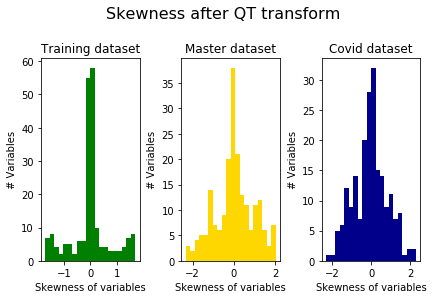

In [19]:
plot_skewness(master_train_trans_qt, master_test_trans_qt, covid_test_trans_qt, 'Skewness after QT transform')
print('The distributions show that several variables in the test datasets retain a skewness above 1 after QT transform')

## Remove outliers

In [20]:
training_clean_qt        = remove_outliers(master_train_trans_qt)
master_clean_qt          = remove_outliers(master_test_trans_qt)
covid_clean_qt          = remove_outliers(covid_test_trans_qt)

/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in less
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan
/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in greater
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan


After outliers removal, the variables have a skeweness within the desired threshold
Bear in mind: one variable needs to be dropped from the master dataset as skeweness remains above 1 even after removal of the outliers


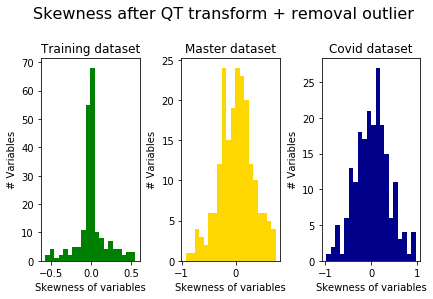

In [21]:
plot_skewness(training_clean_qt, master_clean_qt,covid_clean_qt, 'Skewness after QT transform + removal outlier')
print('After outliers removal, the variables have a skeweness within the desired threshold')
print('Bear in mind: one variable needs to be dropped from the master dataset as skeweness remains above 1 even after removal of the outliers')


In [41]:
print('Mean skewness training:,', np.mean(training_clean_qt.skew()))
print('Median skewness training:,', np.median(training_clean_qt.skew()))

Mean skewness training:, 0.0005689025318003093
Median skewness training:, -0.006706848917638868


In [42]:
print('Mean skewness master testing dataset :,', np.mean(master_clean_qt.skew()))
print('Median skewness master testing dataset:,', np.median(master_clean_qt.skew()))

Mean skewness master testing dataset :, 0.001196723612437766
Median skewness master testing dataset:, 0.01009642277615274


In [43]:
print('Mean skewness covid testing dataset :,', np.mean(covid_clean_qt.skew()))
print('Median skewness covid testing dataset:,', np.median(covid_clean_qt.skew()))

Mean skewness covid testing dataset :, 0.026775321647489924
Median skewness covid testing dataset:, 0.047787230058859015


# Data cleaning - procedure A using Power Transformer (PT)


In [22]:
master_train_trans_pt, master_test_trans_pt  = transform_pt(
             data_train  = selected_var_master_train,
             data_test   = selected_var_master_test, output_train = True, drop_failed=True)

/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in less
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan
/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in greater
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan


* Training dataset
** Successfully transformed 201 variables
** 3 variables could not be transformed successfully
Dropping 3 skewed data that could not be transformed successfully:
bickel_titrator.hyp_discount_rate_medium
bickel_titrator.hyp_discount_rate_large
bickel_titrator.hyp_discount_rate_small
**********************************************************************
* Testing dataset
** Successfully transformed 200 variables
** 4 variables could not be transformed successfully
Dropping 4 skewed data that could not be transformed successfully:
kirby.hyp_discount_rate_large
bickel_titrator.hyp_discount_rate_medium
bickel_titrator.hyp_discount_rate_large
bickel_titrator.hyp_discount_rate_small
**********************************************************************


/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in less
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan
/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in greater
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan


In [23]:
covid_test_trans_pt  = transform_pt(
             data_train = selected_var_master_train, 
             data_test  = selected_var_covid, output_train= False, drop_failed=True)

/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in less
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan
/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in greater
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan


* Training dataset
** Successfully transformed 201 variables
** 3 variables could not be transformed successfully
Dropping 3 skewed data that could not be transformed successfully:
bickel_titrator.hyp_discount_rate_medium
bickel_titrator.hyp_discount_rate_large
bickel_titrator.hyp_discount_rate_small
**********************************************************************
* Testing dataset
** Successfully transformed 196 variables
** 8 variables could not be transformed successfully
Dropping 8 skewed data that could not be transformed successfully:
kirby.hyp_discount_rate_medium
bickel_titrator.hyp_discount_rate_medium
bickel_titrator.hyp_discount_rate_large
bickel_titrator.hyp_discount_rate_small
kirby.hyp_discount_rate_large
dickman_survey.dysfunctional
kirby.hyp_discount_rate_small
upps_impulsivity_survey.positive_urgency
**********************************************************************


/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in less
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan
/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in greater
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan


The distributions show that several variables in the test datasets retain a skewness above 1 after PT transform


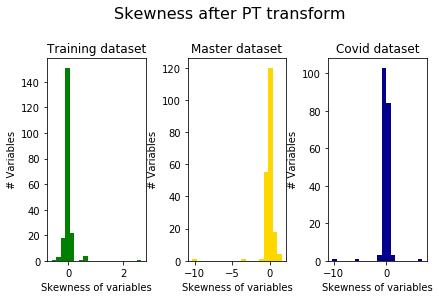

In [24]:
plot_skewness(master_train_trans_pt, master_test_trans_pt, covid_test_trans_pt, 'Skewness after PT transform')
print('The distributions show that several variables in the test datasets retain a skewness above 1 after PT transform')

## Remove outliers

In [25]:
training_clean_pt        = remove_outliers(master_train_trans_pt)
master_clean_pt         = remove_outliers(master_test_trans_pt)
covid_clean_pt          = remove_outliers(covid_test_trans_pt)

/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in less
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan
/SRO/selfregulation/utils/data_preparation_utils.py:700: RuntimeWarning: invalid value encountered in greater
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan


After outliers removal, the variables have a skeweness within the desired threshold
Bear in mind: some variables needed to be dropped as skeweness remains above 1 even after removal of the outliers


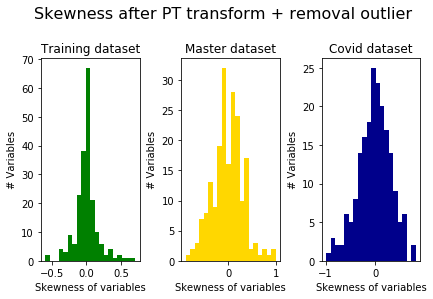

In [26]:
plot_skewness(training_clean_pt, master_clean_pt,covid_clean_pt, 'Skewness after PT transform + removal outlier')
print('After outliers removal, the variables have a skeweness within the desired threshold')
print('Bear in mind: some variables needed to be dropped as skeweness remains above 1 even after removal of the outliers')


In [38]:
print('Mean skewness training:,', np.mean(training_clean_pt.skew()))
print('Median skewness training:,', np.median(training_clean_pt.skew()))

Mean skewness training:, -0.0020319587796381053
Median skewness training:, -0.0018688868080818574


In [39]:
print('Mean skewness master testing dataset :,', np.mean(master_clean_pt.skew()))
print('Median skewness master testing dataset:,', np.median(master_clean_pt.skew()))

Mean skewness master testing dataset :, -0.01204820366458741
Median skewness master testing dataset:, -0.011335564051186974


In [40]:
print('Mean skewness covid testing dataset :,', np.mean(covid_clean_pt.skew()))
print('Median skewness covid testing dataset:,', np.median(covid_clean_pt.skew()))

Mean skewness covid testing dataset :, -0.011939157164659665
Median skewness covid testing dataset:, 0.0006450153723006828


# Data cleaning- procedure B using train_test_split from sklearn
***********************************************************************************************
****************** <font color='red'>INVALID APPROACH DON'T RUN</font>************************
*********************************************************************************************** 

Here the train and test dataset are defined using the train_test_split that splits the overall dataset (testing + train) into random train and test subset. 

By then obtaining the original training (data collected by Ian only) and the testsdatasets (data collected by Ian, and data collected on the same subjects in 2020) the variables have a skewness within the desired threshold and it is not needed to remove outliers.



In [ ]:
#Add suffixes as there might be two subjects with same label
training       = selected_var_master_train.rename(index=lambda s: s + '_train')
master         =  selected_var_master_test.rename(index=lambda s: s + '_test')
covid          = selected_var_covid.rename(index=lambda s: s + '_test')


## Training dataset and master testing assessment 

In [ ]:
X,y = select_data(training, master)
assert len(X) == 493, 'WRONG NUMBER OF SUBJECTS'
assert len(X.columns) == 204, 'WRONG NUMBER OF VARIABLES'

X_train, X_test, X_train_trans, X_test_trans = transform_qt_train_test_split(X, y)
plot_skeweness_2(X_train_trans, X_test_trans, color = 'gold',  title ='Skewness of variables for the random train/test split')

orig_train_trans, orig_master_trans = return_original_datasets_trans(X_train_trans, X_test_trans)
assert len(orig_train_trans) == len(training), 'WRONG NUMBER OF SUBJECTS'
assert len(orig_master_trans) == len(master), 'WRONG NUMBER OF VARIABLES'
plot_skeweness_2(orig_train_trans, orig_master_trans, color = 'gold', title ='Skewness of variables for the original train/test data')

successful_transforms_train= orig_train_trans.loc[:,abs(orig_train_trans.skew())<1]
dropped_vars_train = set(orig_train_trans)-set(successful_transforms_train)

print('** Successfully transformed %s variables for training dataset' % len(successful_transforms_train.columns))
print('** %s variables could not be transformed successfully' % len(dropped_vars_train))

successful_transforms_master= orig_master_trans.loc[:,abs(orig_master_trans.skew())<1]
dropped_vars_master = set(orig_master_trans)-set(successful_transforms_master)
print('** Successfully transformed %s variables for testing dataset' % len(successful_transforms_master.columns))
print('** %s variables could not be transformed successfully' % len(dropped_vars_master))

## Training dataset and covid testing assessment

In [ ]:
X,y = select_data(training, covid)
assert len(X) == 493, 'WRONG NUMBER OF SUBJECTS'
assert len(X.columns) == 204, 'WRONG NUMBER OF VARIABLES'

X_train, X_test, X_train_trans, X_test_trans = transform_qt_train_test_split(X, y)
plot_skeweness_2(X_train_trans, X_test_trans, color = 'blue',  title ='Skewness of variables for the random train/test split')

orig_train_trans, orig_covid_trans = return_original_datasets_trans(X_train_trans, X_test_trans)
assert len(orig_train_trans) == len(training_clean), 'WRONG NUMBER OF SUBJECTS'
assert len(orig_covid_trans) == len(covid_clean), 'WRONG NUMBER OF VARIABLES'
plot_skeweness_2(orig_train_trans, orig_covid_trans, color = 'blue', title ='Skewness of variables for the original train/test data')

successful_transforms_train= orig_train_trans.loc[:,abs(orig_train_trans.skew())<1]
dropped_vars_train = set(orig_train_trans)-set(successful_transforms_train)

print('** Successfully transformed %s variables for training dataset' % len(successful_transforms_train.columns))
print('** %s variables could not be transformed successfully' % len(dropped_vars_train))

successful_transforms_covid= orig_covid_trans.loc[:,abs(orig_covid_trans.skew())<1]
dropped_vars_covid = set(orig_covid_trans)-set(successful_transforms_covid)
print('** Successfully transformed %s variables for testing dataset' % len(successful_transforms_covid.columns))
print('** %s variables could not be transformed successfully' % len(dropped_vars_covid))